# Cleaning the ocean

Did you know that over 8 million tons of plastic are dumped into the oceans each year? Addressing this environmental challenge requires prevention and an efficient marine waste collection strategies. By applying the Vehicle Routing Problem (VRP) to this issue, we hope to optimize the routes of vessels involved in the cleanup, ensuring the most effective removal of waste while conserving time and resources.


### Librairies

Some useful libraries that we are going to use :

In [54]:
import cudaq
from cudaq import spin
import itertools
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.applications import Maxcut, Tsp
from typing import List
from utils.tsp import brute_force_tsp
from utils.graph import generate_point_graph_with_weights, draw_graph, draw_partitionned_graph
from mpi4py import MPI

cudaq.set_target('qpp-cpu') # Comment this to run on GPU

np.random.seed(42)
cudaq.set_random_seed(42)

In [55]:
# Define MPI communication for distributed computing
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

## Problem definition

### Parameters

In [56]:
number_of_garbage = 12
max_weight_per_boat = 250

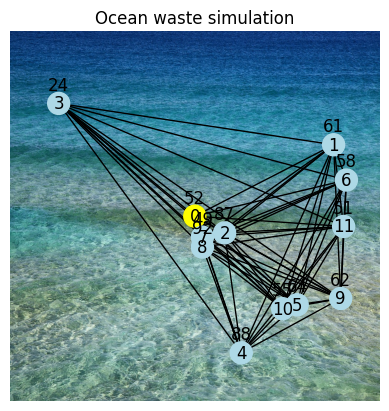

In [57]:
if rank == 0:
    garbage_graph = generate_point_graph_with_weights(number_of_garbage)
    draw_graph(garbage_graph)

## Clustering

Although this seems like an easy problem, it scales very poorly. In fact, with only 15 sites, there are 43 billion possible routes. The problem becomes even worse when you add multiple boats, as the Vehicle Routing Problem (VRP) suggests. Even though this problem may seem insurmountable, we can use various heuristics to help us find reasonably good solutions.

One such solution is to divide the graph that was created using clustering. Once clustered, each part of the problem becomes simpler. An easy way to cluster the problem is by boat. Since each boat will be going in a specific direction, it makes sense for them to cover most of the nearest points.

If we add that each boat has a transport capacity, the problem then more closely resembles the Capacitated Vehicle Routing Problem (CVRP).

Centroid of cluster 0: (0.6746835634336255, 0.5721429986109853)
Centroid of cluster 1: (0.7278837930960051, 0.35500608040974524)
Centroid of cluster 2: (0.7343245862030215, 0.3811989321237757)


<Figure size 1000x800 with 0 Axes>

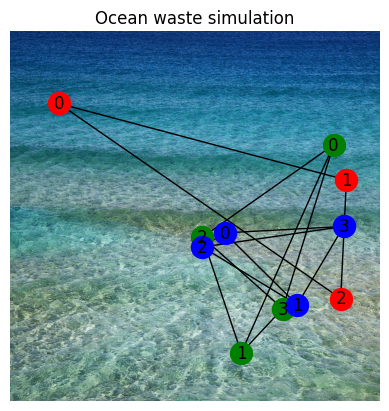

In [66]:

if rank == 0:
    sum_weight = sum(data['weight'] for node, data in garbage_graph.nodes(data=True))
    max_weight = max(data['weight'] for node, data in garbage_graph.nodes(data=True))
    
    number_of_boats = int(np.ceil(sum_weight / max_weight_per_boat))
    
    local_graphs = []
    node_maps = [] 
    
    # Create a local graph for each boat
    for i in range(number_of_boats):
        local_cluster = nx.Graph()
        local_graphs.append(local_cluster)
        node_maps.append({})
        
    nodes = list(garbage_graph.nodes(data=True))
    for idx, (node, data) in enumerate(garbage_graph.nodes(data=True)):
        if idx != 0:  # The initial point doesn't count
            assigned_graph_index = idx % number_of_boats
            new_node_id = len(local_graphs[assigned_graph_index])  # New node ID is the current number of nodes
            local_graphs[assigned_graph_index].add_node(new_node_id, **data)
            node_maps[assigned_graph_index][node] = new_node_id

    for idx, graph in enumerate(local_graphs):
        x_coords = [data['pos'][0] for node, data in graph.nodes(data=True)]
        y_coords = [data['pos'][1] for node, data in graph.nodes(data=True)]
        
        # Add all to all connection
        for node1, node2 in itertools.combinations(graph.nodes(data=True), 2):
            weight = np.sqrt((node1[1]['pos'][0] - node2[1]['pos'][0])**2 + (node1[1]['pos'][1] - node2[1]['pos'][1])**2)
            graph.add_edge(node1[0], node2[0], weight=weight)
        
        if len(x_coords) > 0 and len(y_coords) > 0:
            centroid_x = sum(x_coords) / len(x_coords)
            centroid_y = sum(y_coords) / len(y_coords)
            print(f"Centroid of cluster {idx}: ({centroid_x}, {centroid_y})")
        else:
            print(f"No nodes in cluster {idx} to calculate centroid.")
            
    # Set up the plot
    plt.figure(figsize=(10, 8))
    pos = nx.get_node_attributes(garbage_graph, 'pos')
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']

    draw_partitionned_graph(local_graphs, colors)

In [59]:
def partition_cost_function(graphs):
    cost = 0
    for i in range(len(graphs)): # In each graph
        for j in range(len(graphs[i])): # For each point
            for k in range(len(graphs[i]) - 1): # To every other point
                # eucledient distance between 
                 cost += np.linalg.norm(np.array(list(graphs[i].nodes())[j]) - np.array(list(graphs[i].nodes())[k+1]))
    
        if sum(data['weight'] for node, data in graphs[i].nodes(data=True)) > max_weight_per_boat:
            cost += 10000
    
    return cost

In [67]:
# Scatter everything
if rank == 0:
    graph_queue = [local_graphs[i::size] for i in range(size)]
else:
    graph_queue = None

local_graph_queue = comm.scatter(graph_queue, root=0)

## TSP & QUBO matrix

### QUBO to Maxcut

### TSP Definition

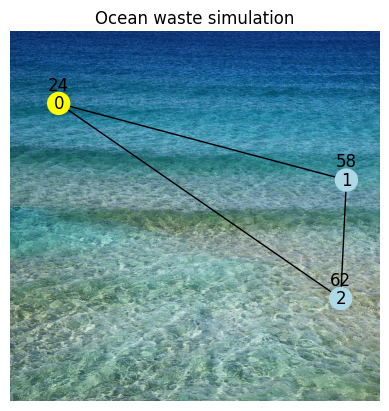

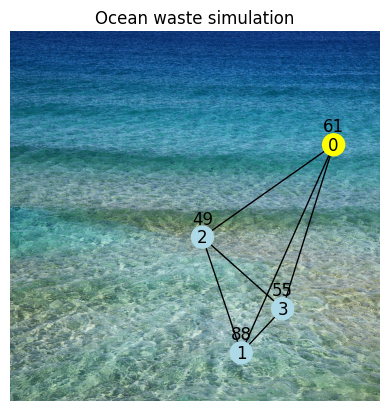

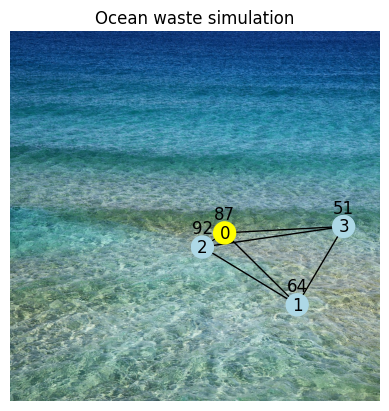

In [68]:
adj_matrix_list = []
for i in local_graph_queue:
    adj_matrix_list.append(nx.to_numpy_array(i))
    draw_graph(i)

### TSP Classical

Graph with 3 nodes and 3 edges
Best order from brute force = (0, 1, 2) with total distance = 2.465217788387313
Graph with 4 nodes and 6 edges
Best order from brute force = (0, 2, 1, 3) with total distance = 1.6710023747736487
Graph with 4 nodes and 6 edges
Best order from brute force = (0, 2, 1, 3) with total distance = 1.1284975523685756


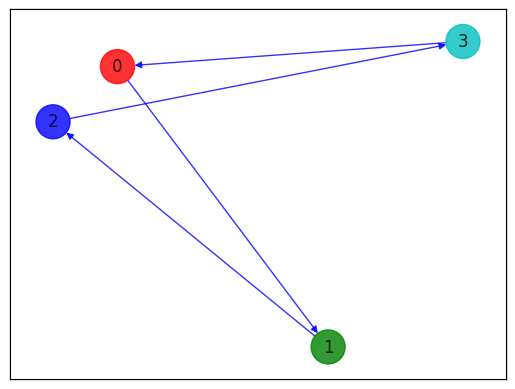

In [69]:
for i in range(len(adj_matrix_list)):
    adj_matrix = adj_matrix_list[i]
    current_graph = local_graph_queue[i]
    
    print(current_graph)
    
    best_distance, best_order = brute_force_tsp(adj_matrix, len(current_graph))
    print(
        "Best order from brute force = "
        + str(best_order)
        + " with total distance = "
        + str(best_distance)
    )
    count = 0
    temp_best_order = []
    for i in current_graph.nodes():
        temp_best_order.append(i)
        count +=1

    pos = nx.get_node_attributes(current_graph, 'pos')


    def draw_tsp_solution(G, order, colors, pos):
        G2 = nx.DiGraph()
        G2.add_nodes_from(G)
        n = len(order)
        for i in range(n):
            j = (i + 1) % n
            G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(
            G2, node_color=colors[:n], edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
        )
        edge_labels = nx.get_edge_attributes(G2, "weight")

    draw_tsp_solution(current_graph, temp_best_order, colors, pos)

### TSP Nvidia

In [70]:
hamiltonians = []

for i in range(len(local_graph_queue)):
    current_graph = local_graph_queue[i]
    tsp = Tsp(current_graph)

    qp = tsp.to_quadratic_program()

    qp2qubo = QuadraticProgramToQubo()
    qubo = qp2qubo.convert(qp)
    qubitOp, offset = qubo.to_ising()
    
    coeffs = qubitOp.coeffs

    hamiltonian = 0

    for i in range(len(qubitOp.paulis)):
        only_one = True
        # find position of first Z
        #print(str(qubitOp.paulis[i]))
        pauli_string = str(qubitOp[i].to_list()[0][0])
        x = pauli_string.index("Z")
        y = x
        # check if their is another Z
        if pauli_string.count("Z") > 1:
            only_one = False
            y = pauli_string.index("Z", x + 1)

        if only_one:
            hamiltonian += coeffs[i] * spin.z(y)
        else:
            hamiltonian += coeffs[i] * spin.z(x) * spin.z(y)
            
    hamiltonians.append(hamiltonian)

In [110]:
counts_list = []

for i in range(len(hamiltonians)):
    hamiltonian = hamiltonians[i]
    # Problem parameters.
    qubit_count: int = len(local_graph_queue[i]) ** 2
    layer_count: int = 2
    parameter_count: int = 2 * layer_count

    @cudaq.kernel
    def kernel_qaoa(qubit_count: int, layer_count: int, thetas: List[float]):
        """QAOA ansatz for Max-Cut"""
        qvector = cudaq.qvector(qubit_count)

        # Create superposition
        h(qvector)

        # Loop over the layers
        for layer in range(layer_count):
            # Loop over the qubits
            # Problem unitary
            for qubit in range(qubit_count):
                x.ctrl(qvector[qubit], qvector[(qubit + 1) % qubit_count])
                rz(2.0 * thetas[layer], qvector[(qubit + 1) % qubit_count])
                x.ctrl(qvector[qubit], qvector[(qubit + 1) % qubit_count])

            # Mixer unitary
            for qubit in range(qubit_count):
                rx(2.0 * thetas[layer + layer_count], qvector[qubit])


    # Specify the optimizer and its initial parameters. Make it repeatable.
    optimizer = cudaq.optimizers.COBYLA()
    optimizer.initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0,
                                                    parameter_count)
    print("Initial parameters = ", optimizer.initial_parameters)


    # Define the objective, return `<state(params) | H | state(params)>`
    def objective(parameters):
        return cudaq.observe(kernel_qaoa, hamiltonian, qubit_count, layer_count,
                            parameters).expectation()


    # Optimize!
    optimal_expectation, optimal_parameters = optimizer.optimize(
        dimensions=parameter_count, function=objective)

    # Print the optimized value and its parameters
    print("Optimal value = ", optimal_expectation)
    print("Optimal parameters = ", optimal_parameters)

    counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, optimal_parameters)
    counts_list.append(counts)

Initial parameters =  [0.17849900813730546, -0.13623456160423025, 0.05532656812041753, 0.016363189560026803]
Optimal value =  -34.896327003830635
Optimal parameters =  [-0.9400791917221779, 1.1769683041216707, 1.9188819999668574, 2.3990076668009515]
Initial parameters =  [0.36220366093426215, 0.2705962519800744, 0.19424476027315352, 0.031174127879711633]


In [84]:
results_list = []
for counts in counts_list:
    results = {}
    for i, key in counts.items():
        results[i] = key
        
    results_list.append(results)

In [97]:
results_sorted_list = []

for results in results_list:
    # Find the maximum frequency
    max_frequency = max(results.values())

    # Find the top 5 most frequent binary strings
    sorted_results = sorted(results.items(), key=lambda item: item[1], reverse=True)
    top_five = sorted_results[:4]
    
    results_sorted_list.append(sorted_results)
    

# Print the results
if rank == 0:
    print("Top 4 most frequent binary strings:")
    for binary_string, frequency in results_sorted_list[0][:4]:
        print(f"Binary string: {binary_string}, Frequency: {frequency}")

Top 4 most frequent binary strings:
Binary string: 011010101, Frequency: 49
Binary string: 101010110, Frequency: 44
Binary string: 001010101, Frequency: 43
Binary string: 101010101, Frequency: 43


011010101
101010010
101010010


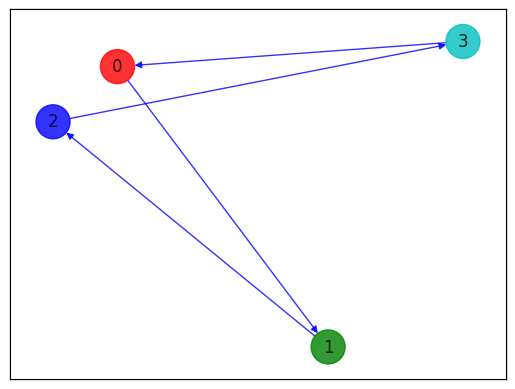

In [109]:
all_results = comm.gather(results_sorted_list, root=0)[0]

if rank == 0:
    def draw_tsp_solution(G, order, colors, pos):
        G2 = nx.DiGraph()
        G2.add_nodes_from(G)
        n = len(order)
        for i in range(n):
            j = (i + 1) % n
            G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(
            G2, node_color=colors[:n], edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
        )
        edge_labels = nx.get_edge_attributes(G2, "weight")

    # Plot all result
    
    def is_value(num_qubit):
        

    for i in range(len(all_results)):
        bitstring_result = all_results[i][0][0]
        while 
    

## Bibliography


https://www.sciencedirect.com/topics/earth-and-planetary-sciences/traveling-salesman-problem#:~:text=With%2C%20say%2C%20n%20%3D%2015,to%20the%20traveling%20salesman%20problem.